# Model Training

In [1]:
# required library imports & variable declarations

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


# set seed value for reproducibility
RANDOM_SEED = 1024

## Data Preparation

### Reading Cleaned Data

In [2]:
import pandas as pd


# define relative data path (according the current path of this notebook) and data file name
DATA_PATH = './scripts/data'

df_train_full = pd.read_csv(f'{DATA_PATH}/train_cleaned.csv.gz')
df_test_full  = pd.read_csv(f'{DATA_PATH}/test_cleaned.csv.gz')

df_train_full.head()

,headline,headline_preprocessed,category
0,Medicare Supplemental Policies: Do You Need One?,medicare supplemental policies do you need one,WELLNESS
1,7 Tips For You And Your Dog This July 4th,7 tips for you and your dog this july 4th,GREEN & ENVIRONMENT
2,The Best Hotel-Hosted Super Bowl Parties In La...,the best hotelhosted super bowl parties in las...,TRAVEL
3,"Even If You Lose The Weight, Obesity May Still...",even if you lose the weight obesity may still ...,HEALTHY LIVING
4,Cocaine Cowboy 'White Boy Rick' Could Be Relea...,cocaine cowboy white boy rick could be release...,CRIME


### Subsampling Data
Our dataset is large (159k+ rows for train and 40k+ for test portions). Needless to say, creating multiple models and tuning them will take a long time. What should we do then?<br>
One simple trick I use in similar cases is to create a representative subsample dataset with smaller number of samples and then do the tuning magics on this one. Later on I can utilize the parameters I discovered and use them on full train data or entire dataset. Although this is not an ideal practice, it provides a good starting point when resources are limited.

In [3]:
# let's shuffle the whole dataframe before subsampling
df_train_full = df_train_full.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# second shuffle with an exponential random seed :D
df_train_full = df_train_full.sample(frac=1, random_state=(RANDOM_SEED**2)).reset_index(drop=True)

To make sure that the subsampled data is representative and similar to our original full dataset, it is advised widely to use __stratified__ method in all sampling scenarios.

In [4]:
from sklearn.model_selection import train_test_split


column_target = 'category'
desired_subsample_size_train = 8000
desired_subsample_size_valid = 8000

# split the data into representative training and validation sets
df_train_subsample, df_valid_subsample = train_test_split(
    df_train_full,
    train_size=desired_subsample_size_train,
    test_size=desired_subsample_size_valid,
    stratify=df_train_full[column_target],
    random_state=RANDOM_SEED
)

### Class Labels

In [5]:
category_map = dict(zip(df_train_full['category'].unique(), range(len(df_train_full['category'].unique()))))

class_labels = list(category_map.keys())
print(f'Classification Labels:\n{class_labels}')

Classification Labels:
['PARENTING', 'GREEN & ENVIRONMENT', 'WORLD NEWS', 'WOMEN', 'ENTERTAINMENT', 'COMEDY', 'STYLE & BEAUTY', 'FOOD & DRINK', 'WELLNESS', 'COLLEGE', 'HEALTHY LIVING', 'TRAVEL', 'POLITICS', 'TECH', 'IMPACT', 'HOME & LIVING', 'BUSINESS', 'CRIME', 'MEDIA', 'BLACK VOICES', 'WEDDINGS', 'QUEER VOICES', 'MONEY', 'SPORTS', 'ARTS & CULTURE', 'LATINO VOICES', 'SCIENCE', 'GOOD NEWS', 'DIVORCE', 'WEIRD NEWS', 'RELIGION', 'FIFTY', 'EDUCATION']


## Creating Language Model Class
Just like convolutional neural networks that enable feature extraction from images, language models like BERT, Roberta, etc. allow us to get contextual embedding or vector representation of an input text by the power of transformers and attention masks, which are pretty sophisticated neural network architecture designs. Our final model will utilize a language model inside. First we get the vector representation of the input from language model, and then pass it to the final layers of neural network. In fact, model training phase consist of fine-tuning the weights of our model's additional hidden layers for our classification task.

But before getting into building our neural network, we need to create a class that will allow us to handle multiple language models in an easy way.

In [6]:
from typing import Union
from transformers import AutoTokenizer, AutoModel


class LanguageModel():
    def __init__(self, model_name: str, device: str, tokenizer_max_length: int=None, fine_tune_model: bool=False):
        self.model = AutoModel.from_pretrained(model_name, return_dict=False)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, return_dict=False)
        self.tokenizer_max_length = tokenizer_max_length

        # model initialization
        self.model.to(device)
        if fine_tune_model:
            self.model.train()
        else:
            self.model.eval()


    def get_embedding_size(self) -> int:
        return self.model.config.hidden_size

    def set_tokenizer_max_length(self, length: int) -> None:
        self.tokenizer_max_length = length

    def estimate_tokenizer_max_length(self, df: pd.DataFrame, text_column_name: str, estimation_type: str = None, adjustment_coefficient: float = 1.0) -> Union[int, dict]:
        '''
        Extracts the token length needed for language model based on desired estimation approach.
        Uses a text column of a dataframe for the estimation of the token length.

        Args:
            df (pd.DataFrame): the dataframe to be used for the estimation
            text_column_name (str): column title of the text column in the dataframe
            estimation_type (str, optional): 'avg', 'max' or 'min' :: defaults to None
            adjustment_coefficient (float): a coefficient to multiply the estimated token length by, defaults to 1.0 :: e.g. 1.2 => 20% larger token length

        Returns:
            int or dict: the estimated token length(s)
        '''
        if adjustment_coefficient <= 0.0:
            raise ValueError("adjust_amount must be a positive float.")

        if estimation_type is not None:
            self.validate_tokenizer_max_length(estimation_type, identifier='estimation_type')

        results = dict()
        # find the rows with the most and least count of words
        word_counts = df[text_column_name].str.split().str.len()
        index_max = word_counts.argmax()
        index_min = word_counts.argmin()
        text_with_max_words = df[text_column_name].iloc[index_max]
        text_with_min_words = df[text_column_name].iloc[index_min]
        # tokenize them and add special tokens, for example `[CLS]` and `[SEP]`
        token_ids_most  = self.tokenizer.encode(text_with_max_words, add_special_tokens=True)
        token_ids_least = self.tokenizer.encode(text_with_min_words, add_special_tokens=True)
        # push 'max' and 'min' token ids length to results list
        results['max'] = round(len(token_ids_most) * adjustment_coefficient)
        results['min'] = round(len(token_ids_least) * adjustment_coefficient)

        # do not continue any further if we don't need to estimate 'avg'
        if estimation_type in ['max', 'min']:
            return results[estimation_type]

        # 'avg' or altogether
        tokens_sum = 0
        all_text = df[text_column_name]
        for text in all_text:
            # tokenize the text and add special tokens, for example `[CLS]` and `[SEP]`
            token_ids = self.tokenizer.encode(text, add_special_tokens=True)
            # update the token length sum
            tokens_sum += len(token_ids)
        results['avg'] = round(round(tokens_sum / len(df)) * adjustment_coefficient)

        return results['avg'] if estimation_type == 'avg' else results

    def validate_tokenizer_max_length(self, token_length: Union[int, str], identifier='token_length') -> bool:
        if (not isinstance(token_length, int) and not isinstance(token_length, str)) or \
        (not isinstance(token_length, str) and not isinstance(token_length, int)):
            raise ValueError(f"Wrong value provided, please check '{identifier}' parameter.")
        if isinstance(token_length, str) and token_length not in ['avg', 'max', 'min']:
            raise ValueError(f"Wrong value provided, please check '{identifier}' parameter.\n\
                            It must be one of 'avg', 'max' or 'min' values.")
        if isinstance(token_length, int) and token_length < 1:
            raise ValueError(f"Wrong value provided, please check '{identifier}' parameter.\n\
                            It must be a positive integer.")
        return True

## Building PyTorch Modules

In [7]:
import os
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Sampler
from transformers import get_linear_schedule_with_warmup


# GPU support
use_gpu = True
cuda_available = torch.cuda.is_available()
device = torch.device('cuda:0' if (cuda_available and use_gpu) else 'cpu')
print('PyTorch runs on => ', device, '\nPyTorch version => ', torch.__version__)
if use_gpu:
    torch.cuda.empty_cache()
torch.set_num_threads(torch.get_num_threads()-1)

# reproducibility (almost)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

PyTorch runs on =>  cuda:0 
PyTorch version =>  1.10.0+cu113


### Dataset Class

In [8]:
import re
import string


# pytorch dataset class
class TextClassificationDataset(Dataset):
    def __init__(self, df: pd.DataFrame, text_column_name: str, label_column_name: str, language_model: LanguageModel, preprocess: bool = False):
        self.df = df
        self.tokenizer = language_model.tokenizer
        self.tokenizer_max_length = language_model.tokenizer_max_length

        if preprocess:
            text_column = f'{text_column_name}_preprocessed'
            self.df[text_column] = df.apply(lambda row: self.preprocess_text(str(row[text_column_name])), axis=1)
        else: text_column = text_column_name

        # get category name and corresponding index from the dataframe
        classes_map  = dict(zip(df[label_column_name].unique(), range(len(df[label_column_name].unique()))))
        self.titles  = df[text_column].to_numpy()
        self.targets = df[label_column_name].map(classes_map).to_numpy()
        self.preprocess_enabled = preprocess


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = str(self.titles[idx])
        label = self.targets[idx]
        text_encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.tokenizer_max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        sample = {
            'token_ids': text_encoding['input_ids'].flatten(),
            'attention_mask': text_encoding['attention_mask'].flatten()}
        output = torch.tensor(label, dtype=torch.long)
        return (sample, output)

    def preprocess_text(self, text: str) -> str:
        text = text.lower()  # convert to lowercase
        text = re.sub('(#)(\S+)', r' \2', text)  # remove hashtags sign
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # remove punctuations
        text = re.sub(' +', ' ', text)  # replace multiple whitespaces with a single space
        text = text.strip()  # remove leading and trailing whitespaces
        return text

### Dataloader Class

In [9]:
# pytorch dataloader class
class TextClassificationDataLoader(DataLoader):
    def __init__(self, dataset: Dataset, batch_size: int = 128, shuffle: bool = False, sampler: Sampler = None, num_workers: int = 0):
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=num_workers)

### Classification Model

In [10]:
# pytorch model class
class TopicClassifier(nn.Module):
    def __init__(self, n_classes: int, language_model: LanguageModel, nn_options: dict):
        super(TopicClassifier, self).__init__()

        self.n_classes = n_classes

        self.lm = language_model.model
        self.lm.eval()  # important: evaluation mode must be enabled for language model, to prevent re-training model on each call

        self.emb_size = language_model.get_embedding_size()  # embedding size

        self.embedding_normalization = nn_options['embedding_normalization']
        if self.embedding_normalization['enabled']:
            if self.embedding_normalization['type'] == 'simple':
                self.emb_normalizer = nn.functional.normalize
            elif self.embedding_normalization['type'] == 'standard':
                self.emb_normalizer = nn.LayerNorm(self.emb_size)
            else:
                raise ValueError(f"Invalid normalization type: {self.normalization['type']}")

        self.n_hidden_layers = nn_options['n_hidden_layers']
        self.use_dropout = nn_options['use_dropout']
        self.dropout_val = nn_options['dropout_val']
        self.use_activation_fn = nn_options['use_activation_fn']
        self.activation_fn = nn_options['activation_fn']

        self.fc = nn.Sequential(
            # hidden layer(s)
            self.generate_hidden_unit(self.n_hidden_layers, self.emb_size),
            # output layer
            nn.Linear(self.emb_size, self.n_classes),
        )

    # generate hidden unit
    def generate_hidden_unit(self, n_layers, layer_size):
        layers = []
        for i in range(n_layers):
            layers.append(nn.Linear(layer_size, layer_size))
            if self.use_activation_fn:
                layers.append(self.activation_fn)
            if self.use_dropout:
                layers.append(nn.Dropout(self.dropout_val))
        block = nn.Sequential(*layers)
        return block

    def forward(self, x):
        _, embedding = self.lm(
            input_ids=x['token_ids'],
            attention_mask=x['attention_mask']
        )
        if self.embedding_normalization['enabled']: embedding = self.emb_normalizer(embedding)

        output = self.fc(embedding)
        return output

### Train Functions

#### Train Step

In [11]:
from sklearn.metrics import accuracy_score, f1_score


def train_step(model, data_loader, loss_fn, optimizer, device):
    model.train()

    losses = []
    predictions = []
    labels = []

    for i, (train_inputs, train_labels) in enumerate(data_loader):
        for input_tensor in train_inputs:
            train_inputs[input_tensor] = train_inputs[input_tensor].to(device)
        train_labels = train_labels.to(device)

        optimizer.zero_grad()
        output = model(train_inputs)

        loss = loss_fn(output, train_labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.3)  # prevent exploding gradients
        optimizer.step()

        _, preds = torch.max(output, dim=1)
        losses.append(loss.item())
        predictions.append(preds.cpu().numpy())
        labels.append(train_labels.data.cpu().numpy())

    # calculate accuracy & f1 score
    predictions = np.concatenate(predictions, axis=0)
    labels = np.concatenate(labels, axis=0)
    f1 = f1_score(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)

    return np.mean(losses), acc, f1

#### Evaluation Step

In [12]:
def eval_model(model, data_loader, loss_fn, device):
    model.eval()

    losses = []
    predictions = []
    labels = []

    with torch.no_grad():
        for i, (test_inputs, test_labels) in enumerate(data_loader):
            for input_tensor in test_inputs:
                test_inputs[input_tensor] = test_inputs[input_tensor].to(device)
            test_labels = test_labels.to(device)

            output = model(test_inputs)
            loss = loss_fn(output, test_labels)

            _, preds = torch.max(output, dim=1)
            losses.append(loss.item())
            predictions.append(preds.cpu().numpy())
            labels.append(test_labels.data.cpu().numpy())

    # calculate accuracy & f1 score
    predictions = np.concatenate(predictions, axis=0)
    labels = np.concatenate(labels, axis=0)
    f1 = f1_score(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)

    return np.mean(losses), acc, f1

#### Train Loop

In [13]:
import copy
from collections import defaultdict


def train(model, train_dataloader, validation_dataloader, loss_fn, optimizer, scheduler, device, n_epochs):
    train_history = defaultdict(list)
    best_epoch = 1
    best_loss = float('inf')
    best_loss_f1 = 0.0
    best_wts = copy.deepcopy(model.state_dict())

    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        print('-' * 10)

        train_loss, train_acc, train_f1 = train_step(model, train_dataloader, loss_fn, optimizer, device)
        print(f'Train Loss: {train_loss:.6f}, Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}')

        validation_loss, validation_acc, validation_f1 = eval_model(model, validation_dataloader, loss_fn, device)
        print(f'Valid Loss: {validation_loss:.6f}, Accuracy: {validation_acc:.4f}, F1: {validation_f1:.4f}', end='\n\n')

        train_history['train_loss'].append(train_loss)
        train_history['train_acc'].append(train_acc)
        train_history['train_f1'].append(train_f1)
        train_history['val_loss'].append(validation_loss)
        train_history['val_acc'].append(validation_acc)
        train_history['val_f1'].append(validation_f1)

        # scheduler.step(validation_loss)
        scheduler.step()

        # update best model stats
        if validation_loss < best_loss:
            best_loss = validation_loss
            best_loss_f1 = validation_f1
            best_wts = copy.deepcopy(model.state_dict())
            best_epoch = (epoch + 1)

    # load best model weights on model object after train is complete
    model.load_state_dict(best_wts)
    # print best model stats
    print(f'best model criteria => least validation loss: {best_loss:.6f} @ epoch {best_epoch} with f1 score of: {best_loss_f1:.4f} ')
    return train_history

## Hyperparameter Tuning & Model Training

### Initializing Instances

In [14]:
# initialize language model
lm_BERT = LanguageModel(model_name='bert-base-uncased', device=device)

# estimate max length of tokenizer
tokenizer_len = lm_BERT.estimate_tokenizer_max_length(
    df=df_train_subsample,
    text_column_name='headline_preprocessed',
    estimation_type='avg',
    adjustment_coefficient=1.5
)

# set tokenizer max length
lm_BERT.set_tokenizer_max_length(tokenizer_len)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
# initialize dataset & dataloader objects

BATCH_SIZE = 128

# train dataset
train_ds = TextClassificationDataset(
    df=df_train_subsample,
    text_column_name='headline_preprocessed',
    label_column_name='category',
    language_model=lm_BERT
)

# validation dataset
valid_ds = TextClassificationDataset(
    df=df_valid_subsample,
    text_column_name='headline_preprocessed',
    label_column_name='category',
    language_model=lm_BERT
)

# train dataloader
train_dl = TextClassificationDataLoader(
    dataset=train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# validation dataloader
valid_dl = TextClassificationDataLoader(
    dataset=valid_ds,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [16]:
# initialize model properties


# neural network architecture parameters
nn_options_dict = {
    # number of hidden layers in the network (the larger the number, the more complex the model)
    'n_hidden_layers': 2,
    'embedding_normalization': {
        'enabled': True,  # whether to normalize the input embedding vectors
        'type': 'standard', # 'simple' | 'standard'  :: 'simple' => normalize to (0~1) range, 'standard' => normalize using mean and standard-deviation
    },
    'use_dropout': False,
    'dropout_val': 0.2,
    'use_activation_fn': True,
    'activation_fn': nn.ReLU()    # nn.LeakyReLU(), nn.SELU(), ...
}

# neural network model
model = TopicClassifier(n_classes=len(class_labels), language_model=lm_BERT, nn_options=nn_options_dict)
model = model.to(device)


# optimizer
optimizer = torch.optim.AdamW(model.parameters())


# loss function
# use CrossEntropy loss given we have a multi-class classification problem
# this loss function also automatically applies softmax to the output of the model
loss_fn = nn.CrossEntropyLoss().to(device)

### Finding Optimal Learning Rate

100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.49E-04


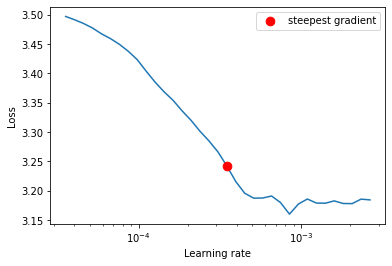

In [18]:
from torch_lr_finder import LRFinder

lr_finder = LRFinder(model, optimizer, loss_fn, device=device)
lr_finder.range_test(train_dl, start_lr=1e-5, end_lr=5e-3, num_iter=50)
# lr_finder.range_test(train_loader=train_dl, val_loader=valid_dl, start_lr=1e-5, end_lr=1e-1, num_iter=50, step_mode="exp")
lr_finder.plot()  # to inspect the loss-learning rate graph
lr_finder.reset()

### Model Training

In [ ]:
%%time

NUM_EPOCHS = 10


# optimizer with newly found optimum learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=3.5e-04)

# scheduler to adjust learning rate during training
total_steps = len(train_dl) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# train model
train_history = train(
    model=model,
    train_dataloader=train_dl,
    validation_dataloader=valid_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    n_epochs=NUM_EPOCHS,
)